In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sb
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
import cv2
import random
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.applications.xception import Xception
from sklearn import metrics

In [2]:
base_skin_dir = os.path.join('..', 'input', 'reorganized')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
all_image_path = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in all_image_path}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# def compute_img_mean_std(image_paths):
#     """
#         computing the mean and std of three channel on the whole dataset,
#         first we should normalize the image from 0-255 to 0-1
#     """

#     img_h, img_w = 224, 224
#     imgs = []
#     means, stdevs = [], []

#     for i in tqdm(range(len(image_paths))):
#         img = cv2.imread(image_paths[i])
#         img = cv2.resize(img, (img_h, img_w))
#         imgs.append(img)

#     imgs = np.stack(imgs, axis=3)
#     print(imgs.shape)

#     imgs = imgs.astype(np.float32) / 255.

#     for i in range(3):
#         pixels = imgs[:, :, i, :].ravel()  # resize to one row
#         means.append(np.mean(pixels))
#         stdevs.append(np.std(pixels))

#     means.reverse()  # BGR --> RGB
#     stdevs.reverse()

#     print("normMean = {}".format(means))
#     print("normStd = {}".format(stdevs))
#     return means,stdevs
# # norm_mean,norm_std = compute_img_mean_std(all_image_path)

In [4]:
df = pd.read_csv(os.path.join('..', 'input', 'HAM10000_metadata.csv'))

# new col
le = LabelEncoder()
le.fit(df['dx'])
LabelEncoder()
print(list(le.classes_))
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['label'] = le.transform(df['dx'])
# df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
# df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0027419.jpg,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0025030.jpg,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0026769.jpg,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0025661.jpg,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\reorganized\bkl\ISIC_0031633.jpg,2


### Nan 

In [5]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
path             0
label            0
dtype: int64

In [6]:
df['age'].fillna((df['age'].mean()), inplace=True)

In [7]:
df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
path            0
label           0
dtype: int64

## Exploring the data

<AxesSubplot: >

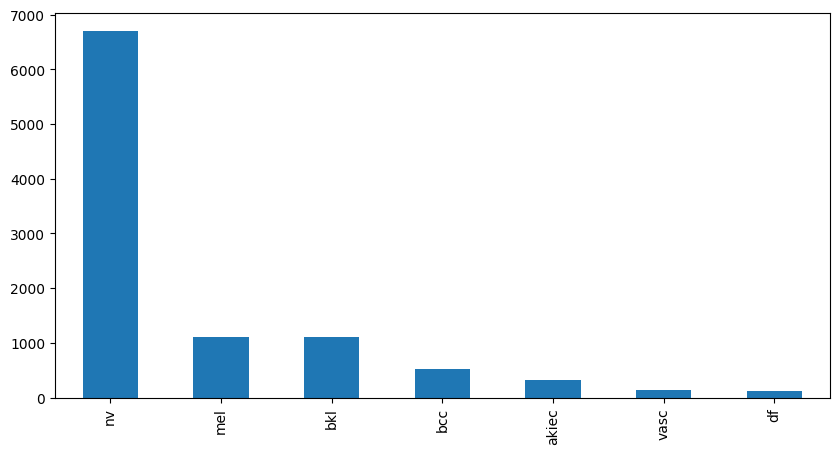

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['dx'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot: >

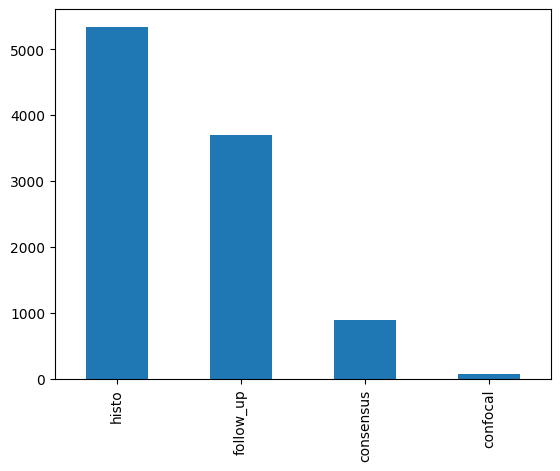

In [9]:
df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot: >

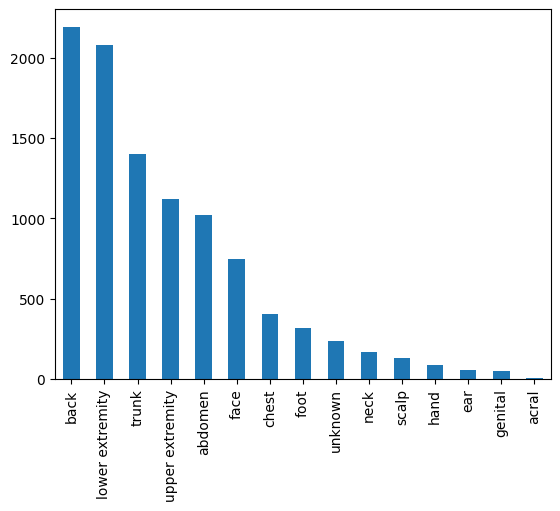

In [10]:
df['localization'].value_counts().plot(kind='bar')

<AxesSubplot: >

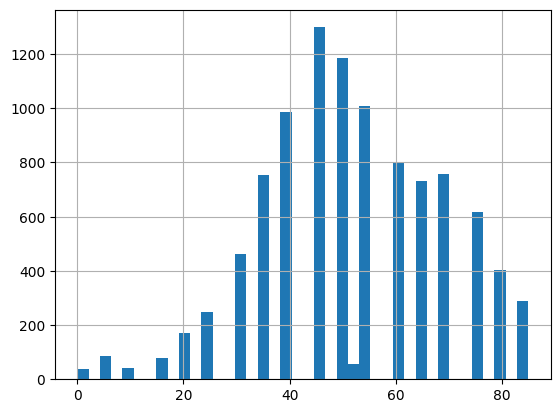

In [11]:
df['age'].hist(bins=40)

<AxesSubplot: >

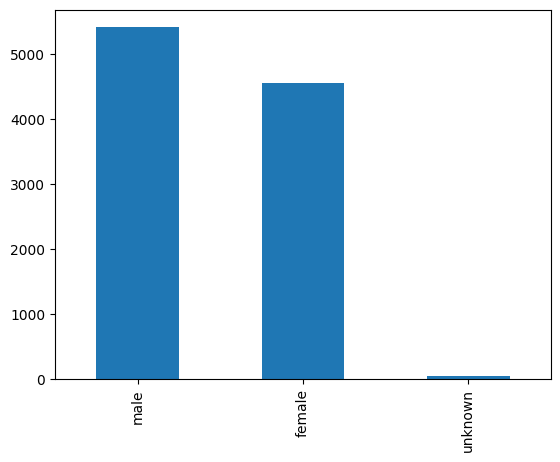

In [12]:
df['sex'].value_counts().plot(kind='bar')

In [13]:
# this will tell us how many images are associated with each lesion_id
df_undup = df.groupby('lesion_id').count()
# now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,label
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [14]:
def check_dup(id):
    if id in list(df_undup['lesion_id']):
        return 'undup'
    else:
        return 'dup'
df['duplicated?'] = df['lesion_id'].apply(check_dup)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,label,duplicated?
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0027419.jpg,2,dup
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0025030.jpg,2,dup
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0026769.jpg,2,dup
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\reorganized\bkl\ISIC_0025661.jpg,2,dup
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\reorganized\bkl\ISIC_0031633.jpg,2,dup


In [15]:
df['duplicated?'].value_counts()

undup    5514
dup      4501
Name: duplicated?, dtype: int64

In [16]:
df_chop = df.loc[(df['dx'] != 'nv') | (df['duplicated?'] == 'undup')]

In [17]:
df_chop['dx'].value_counts()

nv       4415
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [18]:
df_0 = df_chop[df['label'] == 0]
df_1 = df_chop[df['label'] == 1]
df_2 = df_chop[df['label'] == 2]
df_3 = df_chop[df['label'] == 3]
df_4 = df_chop[df['label'] == 4]
df_5 = df_chop[df['label'] == 5]
df_6 = df_chop[df['label'] == 6]

n_samples = 500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42)
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42)
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_0 = df_chop[df['label'] == 0]
C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_1 = df_chop[df['label'] == 1]
C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2 = df_chop[df['label'] == 2]
C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3 = df_chop[df['label'] == 3]
C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_4 = df_chop[df['label'] == 4]
C:\Users\Jeff\AppData\Local\Temp\ipykernel_12060\339830823.py:6: UserWarning: Boolean Series key will be reindexed to ma

In [19]:
df_balanced = pd.concat([df_0_balanced, df_1_balanced, df_2_balanced, df_3_balanced, df_4_balanced, df_5_balanced, df_6_balanced])
print(df_balanced['label'].value_counts())

0    500
1    500
2    500
3    500
4    500
5    500
6    500
Name: label, dtype: int64


In [20]:
df_balanced['image'] = df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((75, 75))))

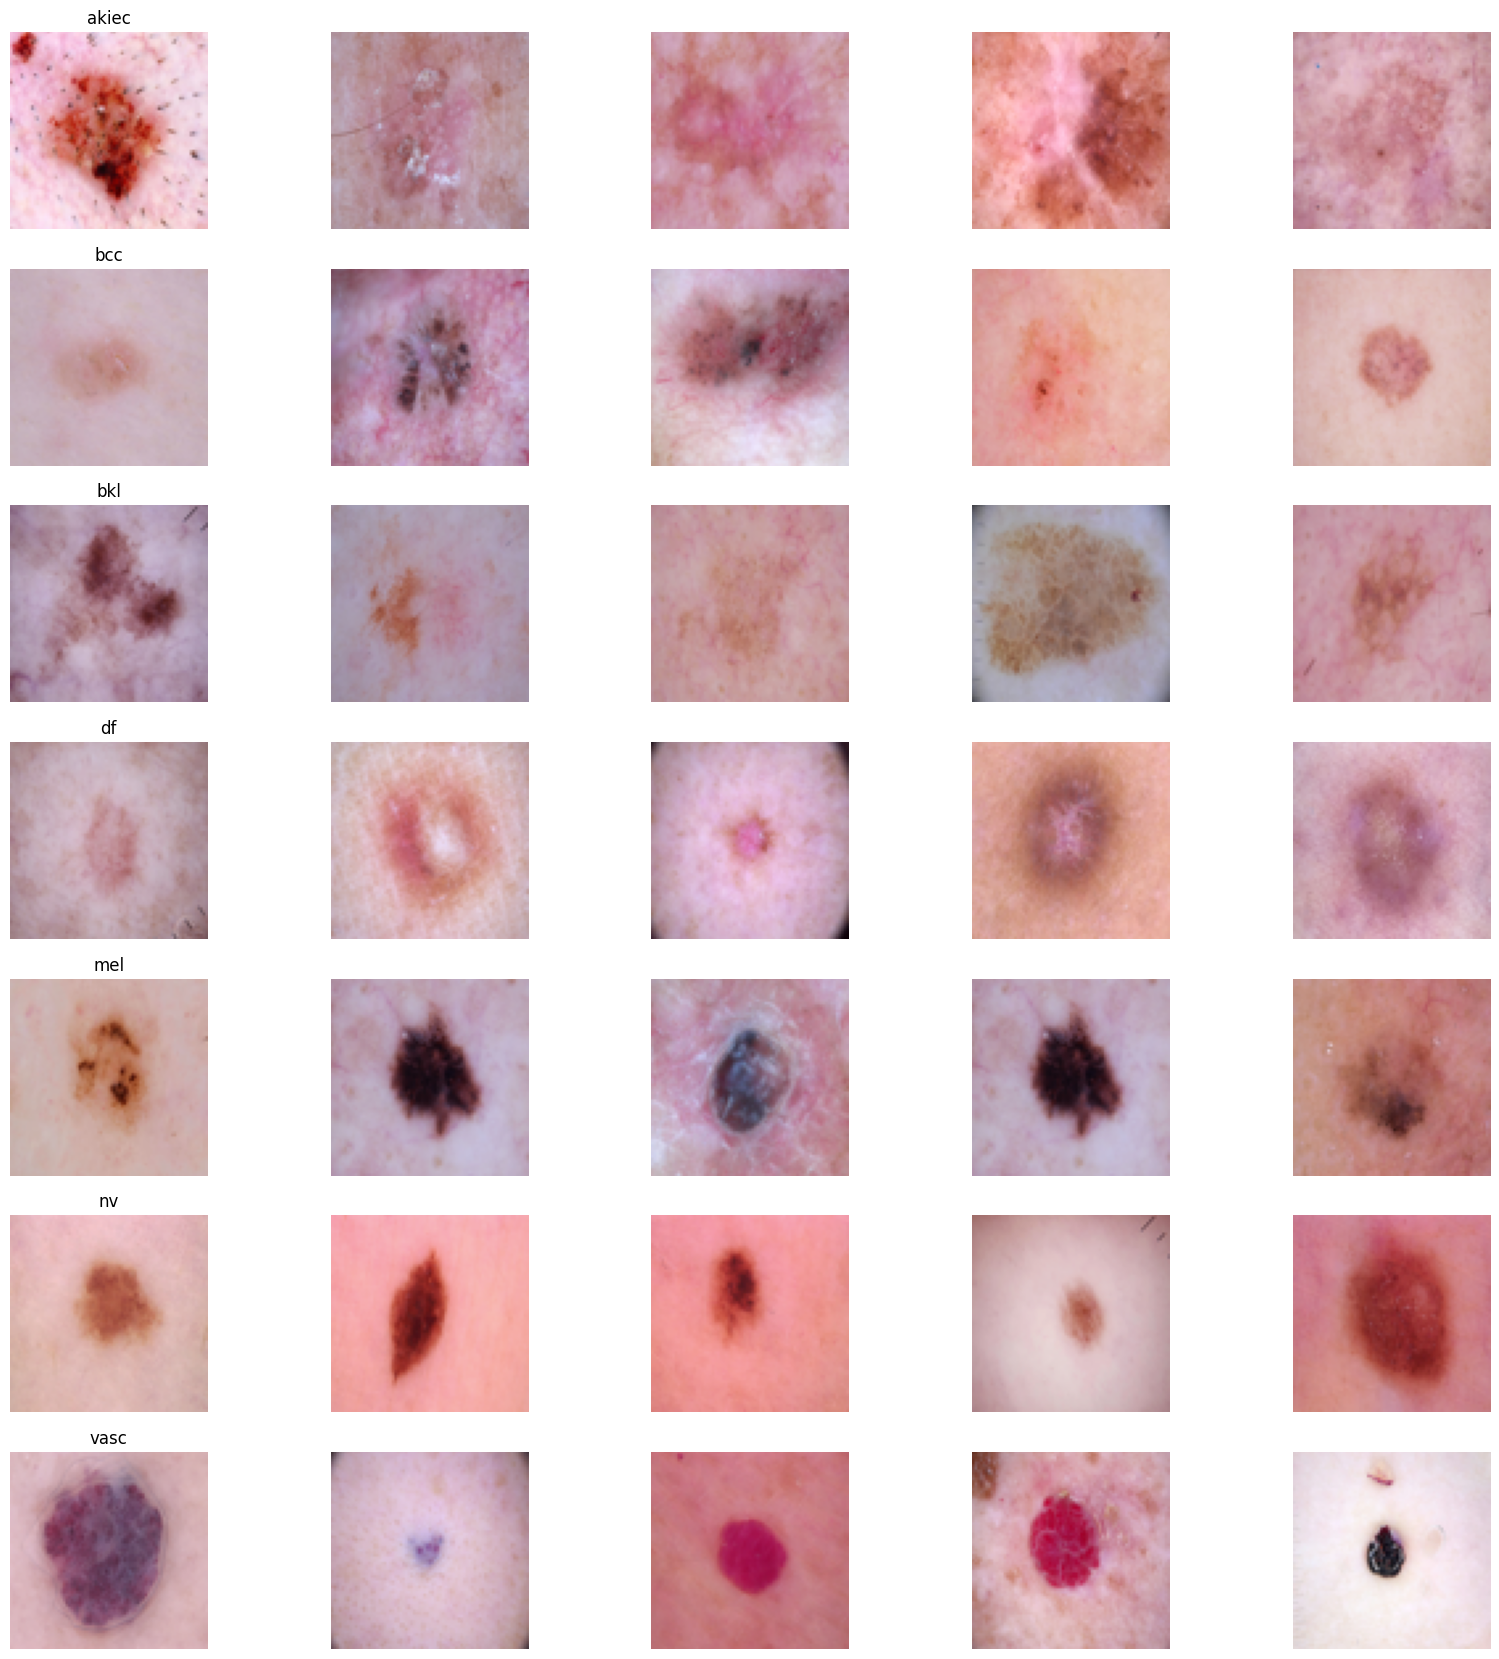

In [21]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [22]:
X = np.asarray(df_balanced['image'].tolist())

In [23]:
print(X.shape)
print(X.dtype)

(3500, 75, 75, 3)
uint8


In [24]:
X = X/255.

In [25]:
print(X.dtype)
print(X[0])

float64
[[[0.57647059 0.42745098 0.39215686]
  [0.62352941 0.49019608 0.45882353]
  [0.62352941 0.48627451 0.44705882]
  ...
  [0.62352941 0.50196078 0.4627451 ]
  [0.32156863 0.23529412 0.20784314]
  [0.56862745 0.43921569 0.37254902]]

 [[0.58823529 0.44313725 0.39607843]
  [0.64313725 0.50980392 0.4745098 ]
  [0.63137255 0.48235294 0.43921569]
  ...
  [0.49019608 0.41960784 0.42745098]
  [0.50196078 0.40392157 0.39215686]
  [0.59215686 0.46666667 0.41568627]]

 [[0.57254902 0.41960784 0.36470588]
  [0.60784314 0.45882353 0.38823529]
  [0.58823529 0.42745098 0.35686275]
  ...
  [0.68235294 0.58431373 0.56862745]
  [0.69019608 0.60392157 0.61176471]
  [0.65490196 0.56470588 0.56470588]]

 ...

 [[0.58431373 0.45490196 0.36078431]
  [0.55294118 0.41176471 0.3254902 ]
  [0.5254902  0.37647059 0.30980392]
  ...
  [0.70196078 0.58431373 0.54117647]
  [0.71764706 0.61568627 0.58823529]
  [0.70588235 0.60392157 0.59215686]]

 [[0.57254902 0.44705882 0.37647059]
  [0.55294118 0.41176471 0.31

In [26]:
X = X.astype(np.float32)

In [27]:
Y = df_balanced['label']
Y_cat = to_categorical(Y, num_classes=7)

In [28]:
print(Y.dtype)
print(Y_cat.dtype)

int32
float32


In [29]:
x_train, x_validate, y_train, y_validate = train_test_split(X, Y_cat, test_size = 0.2, random_state = 2)

In [30]:
print(x_train.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_validate.shape)

(2800, 75, 75, 3)
(700, 75, 75, 3)
(2800, 7)
(700, 7)


In [31]:
x_validate, x_test, y_validate, y_test = train_test_split(x_validate, y_validate, test_size = 0.2, random_state = 2)

In [32]:
print(x_validate.shape)
print(x_test.shape)
print(y_validate.shape)
print(y_test.shape)

(560, 75, 75, 3)
(140, 75, 75, 3)
(560, 7)
(140, 7)


In [33]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 75, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

##############################
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 75, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 75, 75, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 32)       128       
 hNormalization)                                                 
                                                                 
 average_pooling2d (AverageP  (None, 37, 37, 32)       0         
 ooling2D)                                                       
                                                        

In [34]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

c:\Users\Jeff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [35]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [36]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [37]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,
        shear_range=10)  # randomly flip images


In [38]:
datagen.fit(x_train)

In [39]:
## Fit the model
epochs = 130
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate))

Epoch 1/130
280/280 [==============================] - 9s 21ms/step - loss: 1.9647 - accuracy: 0.2918 - val_loss: 2.5569 - val_accuracy: 0.1893
Epoch 2/130
280/280 [==============================] - 5s 18ms/step - loss: 1.6831 - accuracy: 0.3746 - val_loss: 9.8047 - val_accuracy: 0.1946
Epoch 3/130
280/280 [==============================] - 5s 17ms/step - loss: 1.5676 - accuracy: 0.4014 - val_loss: 1.4707 - val_accuracy: 0.4482
Epoch 4/130
280/280 [==============================] - 5s 17ms/step - loss: 1.4469 - accuracy: 0.4421 - val_loss: 1.9117 - val_accuracy: 0.3839
Epoch 5/130
280/280 [==============================] - 5s 17ms/step - loss: 1.4410 - accuracy: 0.4593 - val_loss: 1.5446 - val_accuracy: 0.4018
Epoch 6/130
280/280 [==============================] - 5s 17ms/step - loss: 1.3810 - accuracy: 0.4707 - val_loss: 1.7298 - val_accuracy: 0.4214
Epoch 7/130
280/280 [==============================] - 5s 17ms/step - loss: 1.3648 - accuracy: 0.4754 - val_loss: 1.3507 - val_accuracy:

In [40]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.726786  ;  loss_v = 0.771504
Test: accuracy = 0.735714  ;  loss = 0.678955


In [41]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

18/18 [==============================] - 0s 7ms/step
Classification report for classifier <keras.engine.sequential.Sequential object at 0x00000150C52B8070>:
              precision    recall  f1-score   support

     class 0       0.73      0.49      0.59        74
     class 1       0.74      0.72      0.73        81
     class 2       0.47      0.60      0.53        68
     class 3       0.69      0.97      0.80        90
     class 4       0.76      0.41      0.53        76
     class 5       0.90      0.85      0.87        85
     class 6       0.84      0.95      0.89        86

    accuracy                           0.73       560
   macro avg       0.73      0.71      0.71       560
weighted avg       0.74      0.73      0.72       560




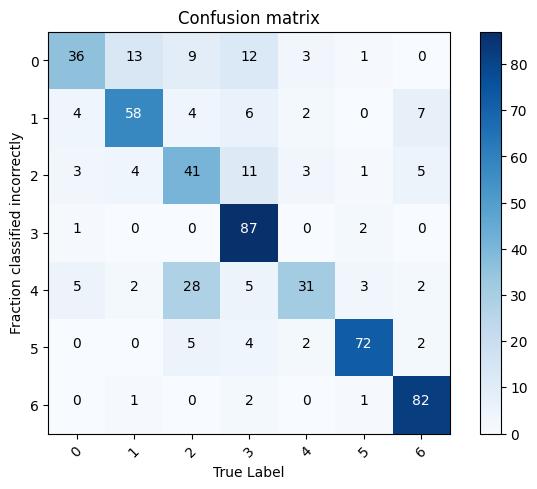

In [42]:

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

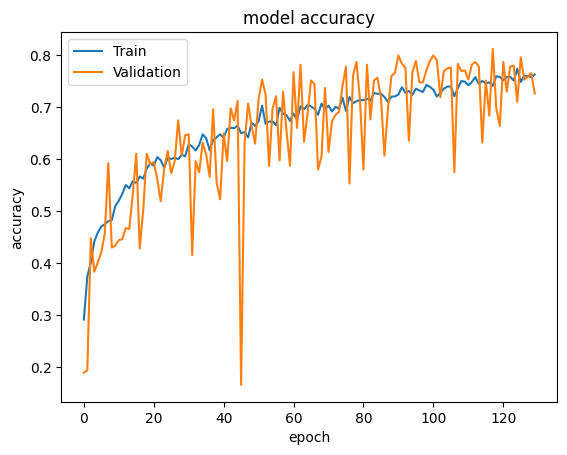

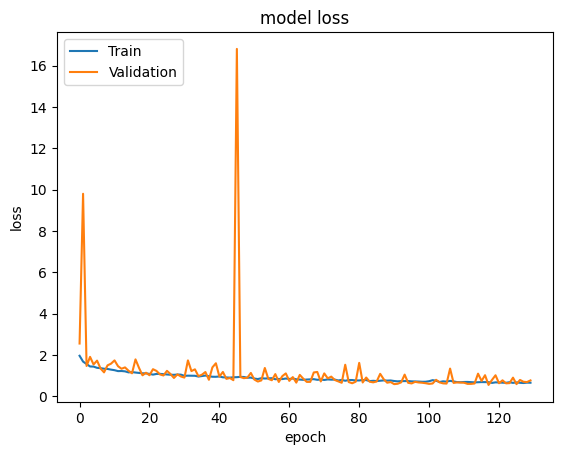

In [43]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [44]:
input_shape = (75, 75, 3)

num_labels = 7

base_model = Xception(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model_2 = Sequential()
model_2.add(base_model)
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                                 
Total params: 21,124,655
Trainable params: 21,070,127
Non-trainable params: 54,528
_________________________________________________________________


In [45]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

c:\Users\Jeff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [46]:
epochs =  40
batch_size = 10
history = model_2.fit(datagen.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=(x_validate.shape[0] // batch_size),
                    callbacks=[learning_rate_reduction])

Epoch 1/40
280/280 [==============================] - 27s 78ms/step - loss: 6.2310 - acc: 0.2864 - val_loss: 5.2121 - val_acc: 0.5054 - lr: 1.0000e-04
Epoch 2/40
280/280 [==============================] - 21s 75ms/step - loss: 4.7070 - acc: 0.5329 - val_loss: 4.4587 - val_acc: 0.6000 - lr: 1.0000e-04
Epoch 3/40
280/280 [==============================] - 21s 75ms/step - loss: 3.7428 - acc: 0.6343 - val_loss: 3.3791 - val_acc: 0.7071 - lr: 1.0000e-04
Epoch 4/40
280/280 [==============================] - 21s 74ms/step - loss: 3.0660 - acc: 0.6746 - val_loss: 3.2003 - val_acc: 0.7089 - lr: 1.0000e-04
Epoch 5/40
280/280 [==============================] - 21s 74ms/step - loss: 2.5738 - acc: 0.6929 - val_loss: 2.3061 - val_acc: 0.7446 - lr: 1.0000e-04
Epoch 6/40
280/280 [==============================] - 21s 74ms/step - loss: 2.1323 - acc: 0.7293 - val_loss: 2.0438 - val_acc: 0.7625 - lr: 1.0000e-04
Epoch 7/40
280/280 [==============================] - 21s 75ms/step - loss: 1.8301 - acc: 0.74

In [47]:
loss, accuracy = model_2.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model_2.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

18/18 [==============================] - 1s 66ms/step - loss: 0.9535 - acc: 0.8946
Validation: accuracy = 0.894643  ;  loss_v = 0.953516
Test: accuracy = 0.828571  ;  loss = 0.861405


In [48]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

18/18 [==============================] - 1s 32ms/step
Classification report for classifier <keras.engine.sequential.Sequential object at 0x0000015267CD2230>:
              precision    recall  f1-score   support

     class 0       0.91      0.91      0.91        74
     class 1       0.93      0.91      0.92        81
     class 2       0.75      0.82      0.78        68
     class 3       0.99      1.00      0.99        90
     class 4       0.80      0.74      0.77        76
     class 5       0.95      0.85      0.89        85
     class 6       0.91      1.00      0.96        86

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.90      0.89      0.89       560




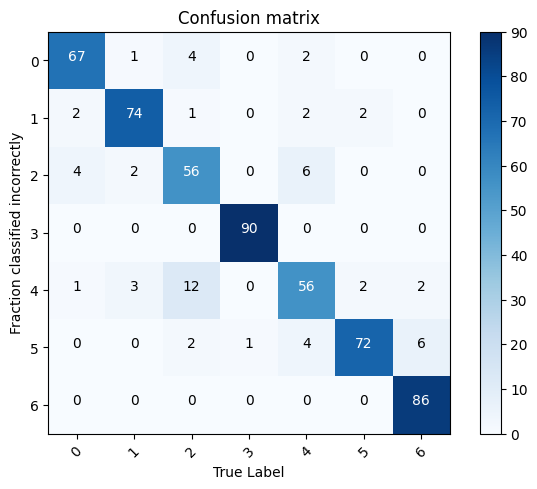

In [49]:
# Predict the values from the validation dataset
Y_pred = model_2.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model_2, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

Text(0.5, 1.0, 'Training and validation loss')

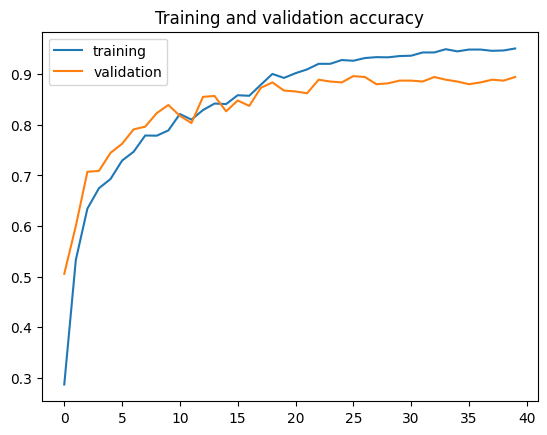

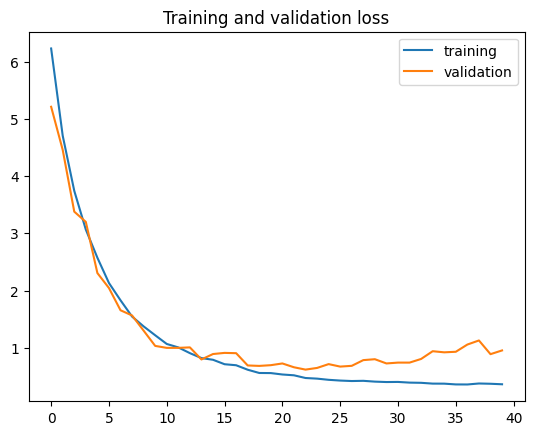

In [50]:
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [51]:
model.save('cnn.h5')

In [52]:
model_2.save('Xception.h5')